In [1]:
using QuantumOptics
using WignerSymbols
using LinearAlgebra
using FFTW
using Plots
using LaTeXStrings
pyplot();

## Sub-Doppler cooling in a $\sigma^--\sigma^+$ molasses configuration
It turns out that if we use an atom with a more complicated electronic structe, we get sub-Doppler cooling through polarization gradients for free in this molasses configuration. 

#### Units
In cooling calculations it's convenient to express all frequencies in units of $\Gamma$, the natural line width. Furthermore, if we chose atomic units (by setting $\hbar = 1$) this means that we effectively solve $\tilde{\mathcal{H}}$, which is related to the original Hamiltonian $\mathcal{H}$ via: $\tilde{\mathcal{H}} = \mathcal{H}/\hbar\Gamma$.

The frequencies $\Omega$ and $\delta$ are understood to be in units of $\Gamma$. This becomes apparent when we look at the jump operator $L$, which, in these units, is simply given by: $L = |g\rangle\langle e|$. (In full units it would carry a factor $\sqrt{\Gamma}$). The full evolution of the density matrix $\rho$ is now given by the master equation
$$
    i\frac{d\rho}{dt} = \left[\mathcal{H}, \rho \right] + L\rho L^\dagger - \frac{1}{2} \left\{ L^\dagger L, \rho \right\}.
$$
(But we don't really need to bother with that since QuantumOptics.jl will do it for us.)

In [2]:
δ = -0.5;
Ω = 0.25;
s₀ = 2 * Ω^2;

We need a basis that includes the three hyperfine ground states $|1, -1\rangle, |1, 0\rangle, |1, 1\rangle$ and the five hyperfine excited states: $|2, -2\rangle \cdots |2, 2\rangle$.
To this order we'll set up an 8-dimensional generic basis, where we'll stick in the couplings by hand. 

In [3]:
Fg = 1;
Fe = 2;
nStates = 2*(Fg + Fe) + 2;
gStates= [[Fg, mFg] for mFg in [-Fg:Fg;]];
eStates = [[Fe, mFe] for mFe in [-Fe:Fe;]];
states = [gStates; eStates];
sbasis = GenericBasis(nStates);

In [4]:
σmincoupling = [[[j+(2*Fg + 1) i 1. * clebschgordan(gStates[i][1], gStates[i][2], 1, -1, eStates[j][1], eStates[j][2] )] for i in [1:(2*Fg + 1);]] for j in [1:(2*Fe + 1);]];
σmincoupling = collect(Iterators.flatten(σmincoupling));
VminMat = vcat(σmincoupling...);
Vminhalf = Ω / 2 * SparseOperator(sbasis, complex(sparse(VminMat[:, 1], VminMat[:, 2], VminMat[:, 3], nStates, nStates)));
Vmintot(z) = exp(-im * z) * Vminhalf + dagger(exp(-im * z) * Vminhalf);

σpluscoupling = [[[j+(2*Fg + 1) i 1. * clebschgordan(gStates[i][1], gStates[i][2], 1, 1, eStates[j][1], eStates[j][2] )] for i in [1:(2*Fg + 1);]] for j in [1:(2*Fe + 1);]];
σpluscoupling = collect(Iterators.flatten(σpluscoupling));
VplusMat = vcat(σpluscoupling...);
Vplushalf = Ω / 2 * SparseOperator(sbasis, complex(sparse(VplusMat[:, 1], VplusMat[:, 2], VplusMat[:, 3], nStates, nStates)));
Vplustot(z) = exp(im * z) * Vplushalf + dagger(exp(im * z) * Vplushalf);

Define the Hamiltonian and force. The force is defined clasically as
$$
    F = -\langle \nabla\mathcal{H} \rangle.
$$

In [5]:
diagonalTerm = SparseOperator(sbasis, complex(Matrix(Diagonal([zeros(2*Fg + 1); ones(2*Fe + 1)]))));

In [6]:
H(z) = Vplustot(z) + Vmintot(z) - δ * diagonalTerm;
F(z) = -im * (-exp(-im * z) * Vminhalf + dagger(exp(-im * z) * Vminhalf) + exp(im * z) * Vplushalf - dagger(exp(im * z) * Vplushalf));

### Decay, dephasing, and jump operators
Define the $\pi$ couplings as well, and set up the jump operators. Decay paths with the same polarization are combined into a single jump operator.

In [7]:
πcoupling = [[[j+(2*Fg + 1) i 1. * clebschgordan(gStates[i][1], gStates[i][2], 1, 0, eStates[j][1], eStates[j][2] )] for i in [1:(2*Fg + 1);]] for j in [1:(2*Fe + 1);]];
πcoupling = collect(Iterators.flatten(πcoupling));

L = [];

# Loop over all excited states, and find paths down
for couplings in (σmincoupling, σpluscoupling, πcoupling)
    cpls = vcat(couplings...);
    
    # Combine all decays with a particular polarization into one jump operator (select nonzero elements)
    cpls = cpls[ cpls[:, 3] .> 0., : ]
    
    # Construct the jump operator describing that decay
    L = vcat(L, SparseOperator(sbasis, sparse(cpls[:, 2], cpls[:, 1], complex(cpls[:, 3]), nStates, nStates)));
end

rate = ones(3);
Ldagger = dagger.(L);

Define the initial condition and the time axis; these are the last ingredients needed for solving the master equation. We define a function that returns the force for some specified velocity. The wave function needs to be evolved for long enough such that it reaches equilibrium. We have found that a time of $4\pi/v$ does the job (the slower the atom, the longer it takes to reach equilibrium).

In [8]:
ψ₀ = Ket(sbasis, [2; 3; 2; zeros(nStates - 3)]/sqrt(17));
mintime = 500;
maxtime = 50000;

function force(v)
    Tₘ = 4*π / abs(v);
    Tₘ = max(mintime, min(maxtime, Tₘ));
    T = [0 : 0.1 : Tₘ;];
    Hₜ = (t, ρ) -> (H(v * t), L, Ldagger);
    tout, ρₜ = timeevolution.master_dynamic(T, ψ₀, Hₜ; rates = rate);
    Fexpect = real(expect.(F.(tout * v), ρₜ))
    return Fexpect[end];
end;

#### Run and plot

In [9]:
vmin = 4*π / maxtime;         # The lowest velocity we can use such that the evolution converges within maxtime
vs = ([-1:0.01:1;].^3);      # Set up such that we sample a little denser around v = 0
vs = vs[ abs.(vs) .> vmin];    # Remove the velocities for which we do not run the evolution long enough
forces = force.(vs);

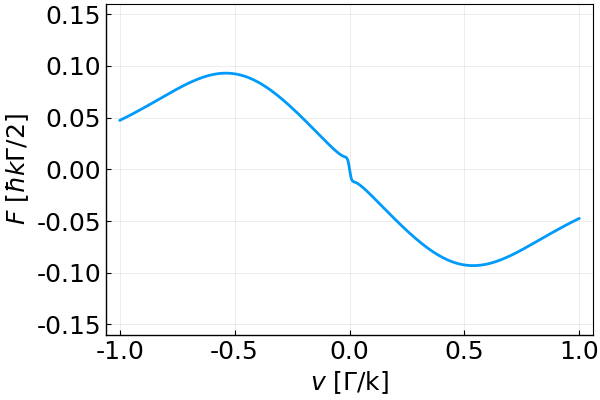

In [10]:
plot(vs, 2*forces,
    width = 2,
    ylims = (-0.16, 0.16),
    xlabel = L"$v$ [$\Gamma$/k]",
    ylabel = L"$F$ [$\hbar k\Gamma / 2$]",
    frame = true,
    xtickfont = font(15),
    ytickfont = font(15),
    xaxis = font(18),
    yaxis = font(18),
    label = "")

Compare to Fig. 8 from the [paper by Jean Dalibard and Claude Cohen-Tannoudji](https://www.osapublishing.org/josab/abstract.cfm?uri=josab-6-11-2023). (We've included an extra factor of 2 to make sure the y axes agree.)

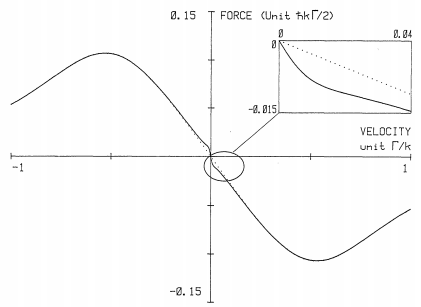

### Steady state convergence & behavior
How does the system converge to the steady state, and what are the population distributions there? (Actually, $s_0 = 2$, so there's a significant portion of population in the excited state.)

In [11]:
vₘ = 0.01;
Tₘ = 4*π / abs(vₘ);
Tₘ = max(mintime, min(maxtime, Tₘ));
ψ₀ = Ket(sbasis, sqrt.([13/34; 4/17; 13/34; zeros(nStates - 3)]));
T = [0:1:Tₘ;];
Hₜ = (t, ρ) -> (H(vₘ * t), L, Ldagger);
tout, ρₜ = timeevolution.master_dynamic(T, ψ₀, Hₜ; rates = rate);

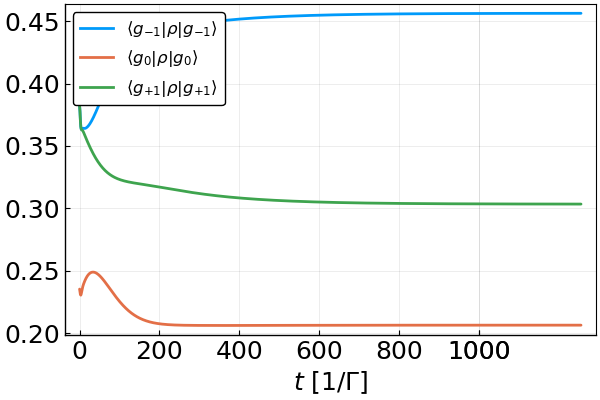

In [12]:
plot(tout, real(expect(DenseOperator(sbasis, Diagonal([1.; zeros(nStates - 1)])), ρₜ)), label = L"$\langle g_{-1} | \rho | g_{-1} \rangle$", width = 2)
plot!(tout, real(expect(DenseOperator(sbasis, Diagonal([0.; 1.; zeros(nStates - 2)])), ρₜ)), label = L"$\langle g_{0} | \rho | g_{0} \rangle$",
    frame = true,
    width = 2,
    xlabel = L"$t$ [$1/\Gamma$]",
    xtickfont = font(15),
    ytickfont = font(15),
    xaxis = font(18),
    yaxis = font(18),
    legendfont = font(12))
plot!(tout, real(expect(DenseOperator(sbasis, Diagonal([0.; 0.; 1.; zeros(nStates - 3)])), ρₜ)), label = L"$\langle g_{+1} | \rho | g_{+1} \rangle$", width = 2)

In [13]:
ρOperator(i, j) = SparseOperator(sbasis, sparse([j], [i], [complex(1.)], nStates, nStates));
pops = [real(expect(ρOperator(i, i), ρₜ[end])) for i in 1:3]

3-element Array{Float64,1}:
 0.4562779143899337 
 0.20639065367110002
 0.3034128452254924 

Expectation values obtained from adiabatic elimination:

In [14]:
1/34. * (13 - 240 * vₘ * δ / (s₀ * (5 + 4*δ^2))), 4/17, 1/34. * (13 + 240 * vₘ * δ / (s₀ * (5 + 4*δ^2)))

(0.4294117647058823, 0.23529411764705882, 0.33529411764705885)

### Compare coherences to analytical result

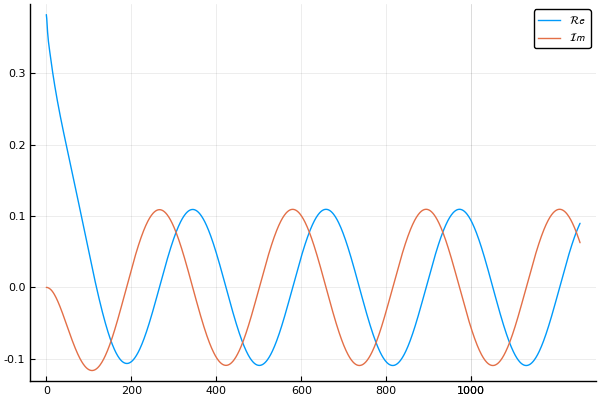

In [15]:
plot(tout, real(expect(ρOperator(1, 3), ρₜ)), label = L"$\mathcal{Re}$")
plot!(tout, imag(expect(ρOperator(1, 3), ρₜ)), label = L"$\mathcal{Im}$")

Analytically, we expect the real part of the ground-state coherence $\rho(g_{1},g_{-1})$ to equal $5/34$:

In [16]:
5/34

0.14705882352941177

Doing the numerics, we get:

In [17]:
expect(ρOperator(1, 3), ρₜ[end])

0.08983785867613278 + 0.06260449184326863im